# Exploration OSMNX Parking spots

In this notebook I will explore the osmnx package for its parking spot data.

In [1]:
#importing packages
%matplotlib inline

import seaborn as sns
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import geopandas as gpd
import folium
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import mapclassify
from sklearn.preprocessing import StandardScaler
import osmnx as ox

C:\Python\Anaconda\envs\SpatialDataScience\Lib\site-packages\spaghetti\network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
C:\Python\Anaconda\envs\SpatialDataScience\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#cities of interest
cities_int = ['paris, France','taipeh, Taiwan', 'toronto, Canada', 'melbourne, Australia', 'hamburg, Germany', 'london, UK']

## Creating Dataframes

In [3]:
def parking_city (city):
    df_parking=ox.features.features_from_place(city, tags = {"parking": True}, which_result=None, buffer_dist=None)
    return df_parking

In [4]:
df_parking_paris = parking_city(cities_int[0])
df_parking_taipeh = parking_city(cities_int[1])
df_parking_toronto = parking_city(cities_int[2])
df_parking_melbourne = parking_city(cities_int[3])
df_parking_hamburg = parking_city(cities_int[4])
#london somehow takes years for me to load
df_parking_london = parking_city(cities_int[5])

## Inspecting Dataframes

In [45]:
column_names = df_parking_paris.columns.tolist()
print(column_names)

['barrier', 'motor_vehicle', 'geometry', 'access', 'amenity', 'capacity:disabled', 'fee', 'layer', 'maxheight', 'name', 'opening_hours', 'operator', 'parking', 'addr:city', 'addr:housenumber', 'addr:postcode', 'addr:street', 'capacity', 'man_made', 'park_ride', 'phone', 'supervised', 'website', 'brand', 'brand:wikidata', 'brand:wikipedia', 'operator:wikidata', 'operator:wikipedia', 'description:fr', 'wheelchair', 'maxspeed', 'level', 'operator:type', 'surface', 'contact:city', 'contact:housenumber', 'contact:phone', 'contact:postcode', 'contact:street', 'contact:website', 'source', 'address', 'foot', 'ref', 'covered', 'surveillance', 'payment:mastercard', 'survey:date', 'entrance', 'name:de', 'name:es', 'name:it', 'name:pt', 'name:ru', 'check_date:fee', 'phone:FR', 'addr:country', 'lit', 'service:bicycle:rental', 'architect', 'bicycle', 'shelter', 'bus', 'capacity:bus', 'capacity:car', 'description', 'vehicle', 'charge', 'payment:bank_card', 'payment:cash', 'motorcar', 'bicycle_parking

In [74]:
unique_letters = df_parking_paris.index.get_level_values('element_type').unique()
print(unique_letters)

Index(['node', 'way', 'relation'], dtype='object', name='element_type')


In [77]:
df_parking_paris["type"]

element_type  osmid    
node          186469017             NaN
              213173448             NaN
              218117881             NaN
              218119662             NaN
              241110562             NaN
                               ...     
relation      6067077      multipolygon
              6108814      multipolygon
              8777647      multipolygon
              14206314     multipolygon
              15572978     multipolygon
Name: type, Length: 1704, dtype: object

The parking spots are described as points (node) or polygons (ways, relations).

## Inspecting parking classes

In [86]:
df_parking_paris.head()

barrier motor_vehicle                  geometry access  \
element_type osmid                                                              
node         186469017     NaN           NaN  POINT (2.35571 48.87582)    yes   
             213173448     NaN           NaN  POINT (2.35339 48.87304)    yes   
             218117881     NaN           NaN  POINT (2.34971 48.85695)    yes   
             218119662     NaN           NaN  POINT (2.35352 48.85630)    NaN   
             241110562     NaN           NaN  POINT (2.29966 48.84146)    NaN   

                                 amenity capacity:disabled  fee layer  \
element_type osmid                                                      
node         186469017           parking                13  yes    -1   
             213173448           parking               NaN  yes   NaN   
             218117881           parking               NaN  yes    -1   
             218119662  parking_entrance               NaN  yes   NaN   
             241110562  parking_entrance               NaN  NaN   NaN   

                       maxheight                                name  ...  \
element_type osmid                                                    ...   
node         186469017       1.9    Parking Alban Satragne - Magenta  ...   
             213173448       NaN                                 NaN  ...   
             218117881      1.85              Parking Hôtel de Ville  ...   
             218119662       NaN                        Lobau Rivoli  ...   
             241110562       NaN  Parking Lecourbe - Mairie du XVème  ...   

                       capacity:charging parking:orientation taxi  \
element_type osmid                                                  
node         186469017               NaN                 NaN  NaN   
             213173448               NaN                 NaN  NaN   
             218117881               NaN                 NaN  NaN   
             218119662               NaN                 NaN  NaN   
             241110562               NaN                 NaN  NaN   

                       description:en comment delivery capacity:delivery ways  \
element_type osmid                                                              
node         186469017            NaN     NaN      NaN               NaN  NaN   
             213173448            NaN     NaN      NaN               NaN  NaN   
             218117881            NaN     NaN      NaN               NaN  NaN   
             218119662            NaN     NaN      NaN               NaN  NaN   
             241110562            NaN     NaN      NaN               NaN  NaN   

                       type           city  
element_type osmid                          
node         186469017  NaN  paris, France  
             213173448  NaN  paris, France  
             218117881  NaN  paris, France  
             218119662  NaN  paris, France  
             241110562  NaN  paris, France  

[5 rows x 146 columns]

In [7]:
df_parking_taipeh.head()

amenity                    geometry  fee  \
element_type osmid                                                           
node         877258318   parking_entrance  POINT (121.52217 25.10575)  yes   
             924215099            parking  POINT (121.54277 25.01502)  NaN   
             1493009261  parking_entrance  POINT (121.53831 25.06422)  NaN   
             1503664837  parking_entrance  POINT (121.56326 25.03410)  NaN   
             1703072018  parking_entrance  POINT (121.54028 24.98849)  NaN   

                        layer      parking             name          name:zh  \
element_type osmid                                                             
node         877258318     -1  underground              NaN              NaN   
             924215099     -1  underground  國立台灣科技大學研揚大樓停車場  國立台灣科技大學研揚大樓停車場   
             1493009261   NaN  underground              NaN              NaN   
             1503664837   NaN  underground              NaN              NaN   
             1703072018   NaN  underground        景美國小地下停車場              NaN   

                            name:zh-Hans     name:zh-Hant barrier  ... type  \
element_type osmid                                                 ...        
node         877258318               NaN              NaN     NaN  ...  NaN   
             924215099   国立台湾科技大学研扬大楼停车场  國立台灣科技大學研揚大樓停車場     NaN  ...  NaN   
             1493009261              NaN              NaN     NaN  ...  NaN   
             1503664837              NaN              NaN     NaN  ...  NaN   
             1703072018              NaN              NaN     NaN  ...  NaN   

                        owner description:url operator:en operator:zh power  \
element_type osmid                                                            
node         877258318    NaN             NaN         NaN         NaN   NaN   
             924215099    NaN             NaN         NaN         NaN   NaN   
             1493009261   NaN             NaN         NaN         NaN   NaN   
             1503664837   NaN             NaN         NaN         NaN   NaN   
             1703072018   NaN             NaN         NaN         NaN   NaN   

                        rating substation utility voltage  
element_type osmid                                         
node         877258318     NaN        NaN     NaN     NaN  
             924215099     NaN        NaN     NaN     NaN  
             1493009261    NaN        NaN     NaN     NaN  
             1503664837    NaN        NaN     NaN     NaN  
             1703072018    NaN        NaN     NaN     NaN  

[5 rows x 134 columns]

Not all cities seem to have the same data on parking (different number of columns). The parking classes also seem to differ but we might be able to clean them.

In [18]:
def parking_class (df_parking_city,city):
    amenities = df_parking_city["amenity"].unique()
    parking = df_parking_city["parking"].unique()
    print("Amenities of ",city,":",amenities)
    print("Parking of ",city,":",parking)
    return

In [21]:
parking_class(df_parking_paris,cities_int[0])
parking_class(df_parking_taipeh,cities_int[1])
parking_class(df_parking_toronto,cities_int[2])
parking_class(df_parking_melbourne,cities_int[3])
parking_class(df_parking_hamburg,cities_int[4])
parking_class(df_parking_london,cities_int[5])

Amenities of  paris, France : ['parking' 'parking_entrance' 'motorcycle_parking' 'bicycle_parking'
 'parking_space' nan]
Parking of  paris, France : ['underground' 'surface' 'multi-storey' 'garage_boxes' 'lane'
 'street_side' 'sheds' 'floor' 'no' 'rooftop' 'disabled' 'delivery'
 'carports']
Amenities of  taipeh, Taiwan : ['parking_entrance' 'parking' 'parking_entrance;parking'
 'motorcycle_parking' 'parking_space' nan 'bicycle_parking']
Parking of  taipeh, Taiwan : ['underground' 'multi-storey' 'surface' 'rooftop' 'underground;surface'
 'sheds' 'lane' 'street_side' 'carports' '唭哩岸轉乘停車場']
Amenities of  toronto, Canada : ['parking' 'parking_entrance' nan 'dentist' 'parking_exit' 'parking_space'
 'motorcycle_parking' 'restaurant' 'library']
Parking of  toronto, Canada : ['underground' 'multi-storey' 'surface' 'garage' 'free' 'paid'
 'street_side' 'no' 'rooftop' 'lane' 'half_on_kerb']
Amenities of  melbourne, Australia : ['parking' 'parking_entrance' nan 'car_sharing' 'bicycle_parking'
 'p

In [24]:
def plot_parking_on_city(df_parking_city,city):
    # Get city boundaries
    city_polygon = ox.geocode_to_gdf(city)
    # Plot city boundaries
    ax = city_polygon.plot(facecolor='none', edgecolor='black', figsize=(10, 10))
    # Plot parking data on top of city boundaries
    df_parking_city.plot(ax=ax, color='red', alpha=0.7, markersize=8)
    plt.show()

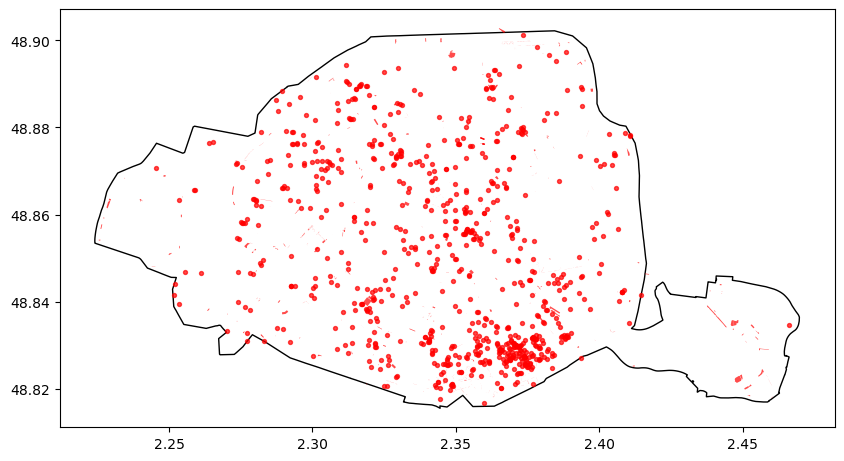

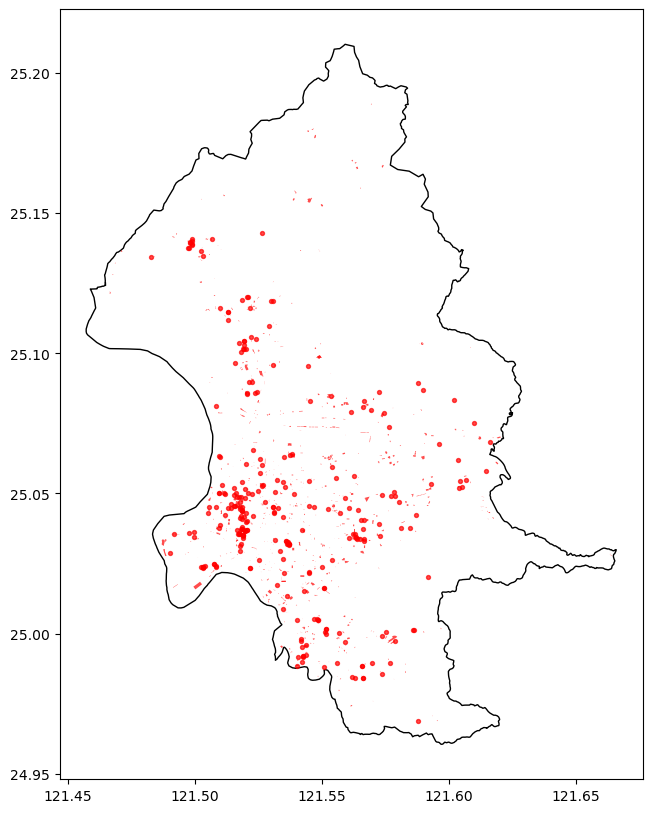

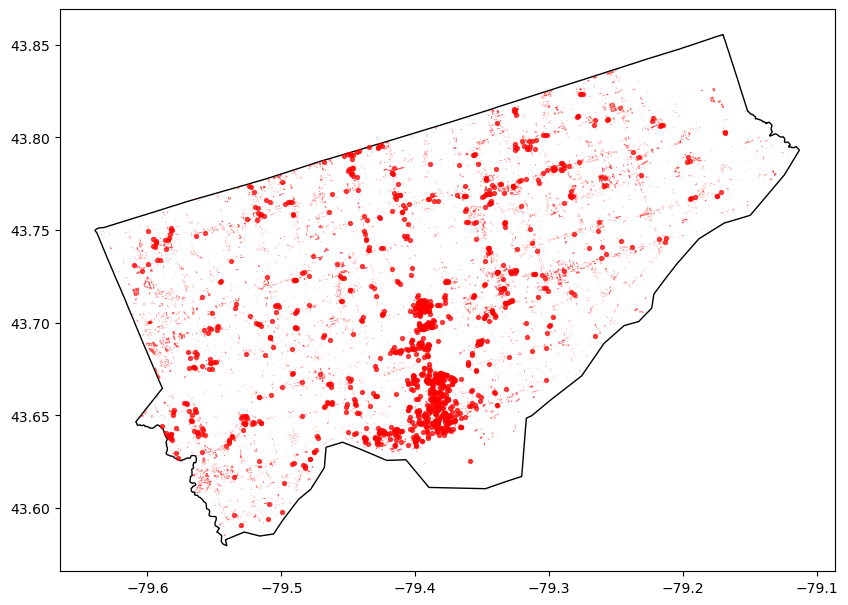

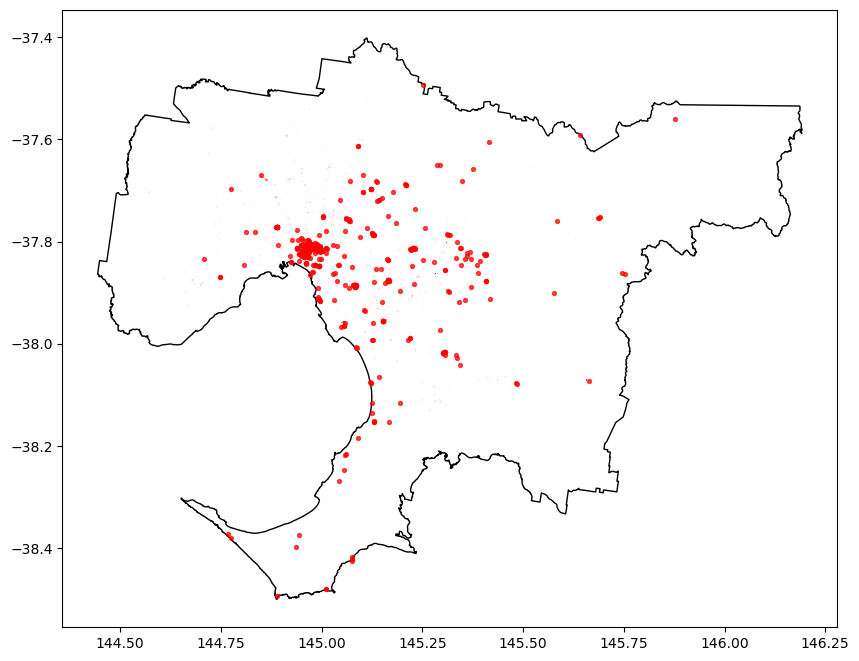

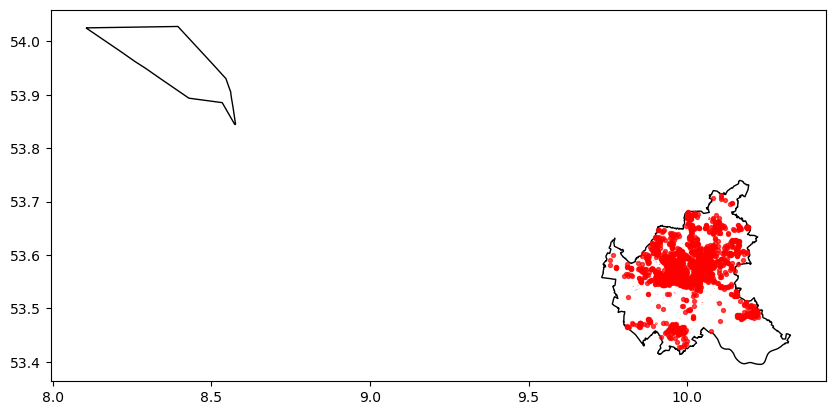

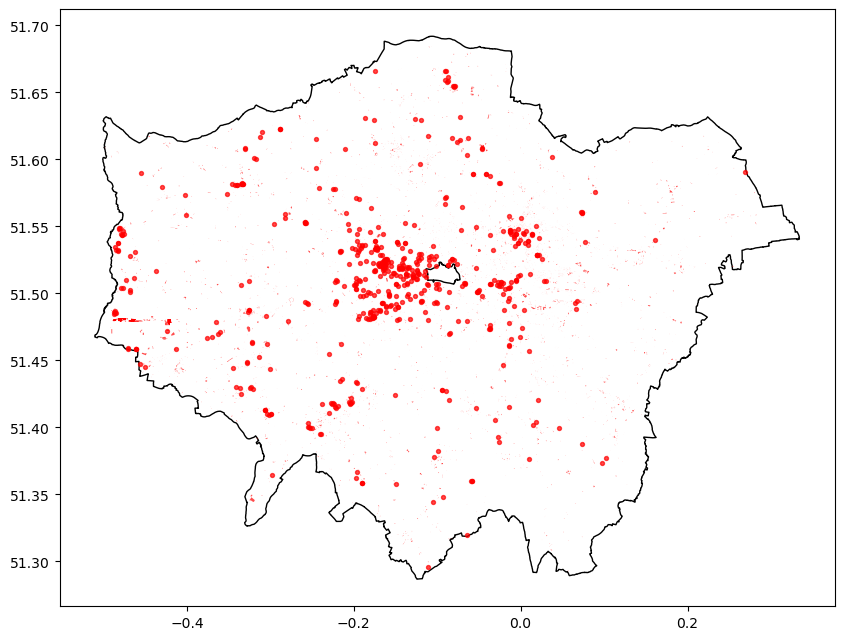

In [39]:
plot_parking_on_city(df_parking_paris,cities_int[0])
plot_parking_on_city(df_parking_taipeh,cities_int[1])
plot_parking_on_city(df_parking_toronto,cities_int[2])
plot_parking_on_city(df_parking_melbourne,cities_int[3])
plot_parking_on_city(df_parking_hamburg,cities_int[4])
plot_parking_on_city(df_parking_london,cities_int[5])

In [32]:
def plot_parking_classes (df_parking_city,city):
    df_parking_city['parking'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Parking Type')
    plt.ylabel('Frequency')
    plt.title('Parking Types Histogram of '+str(city))
    plt.show()
    return

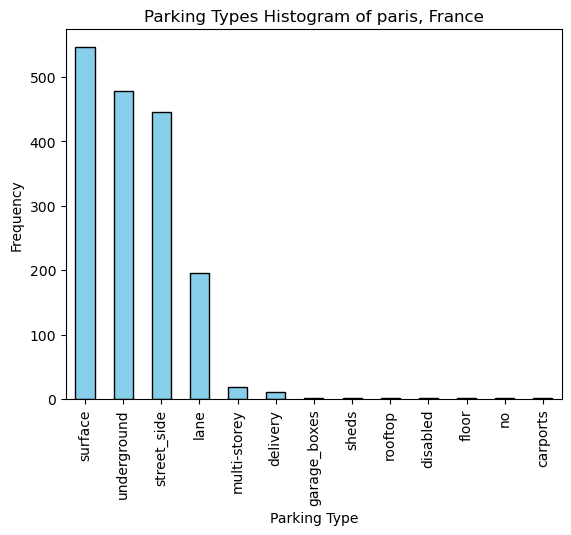

C:\Python\Anaconda\envs\SpatialDataScience\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21805 (\N{CJK UNIFIED IDEOGRAPH-552D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python\Anaconda\envs\SpatialDataScience\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21737 (\N{CJK UNIFIED IDEOGRAPH-54E9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python\Anaconda\envs\SpatialDataScience\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23736 (\N{CJK UNIFIED IDEOGRAPH-5CB8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python\Anaconda\envs\SpatialDataScience\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36681 (\N{CJK UNIFIED IDEOGRAPH-8F49}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Python\Anaconda\envs\SpatialDataScience\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20056 (\

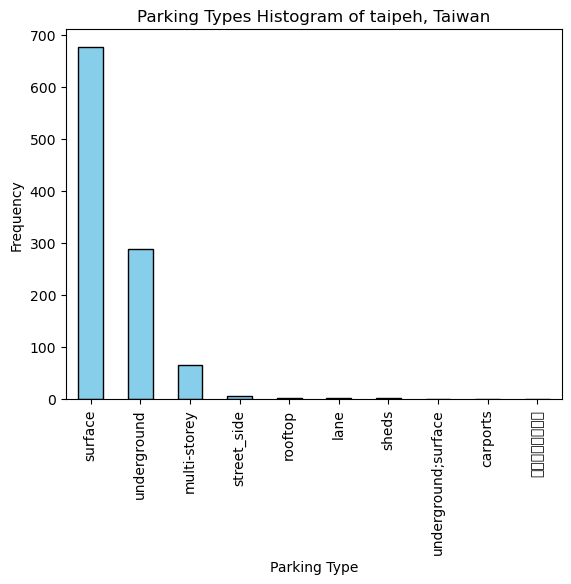

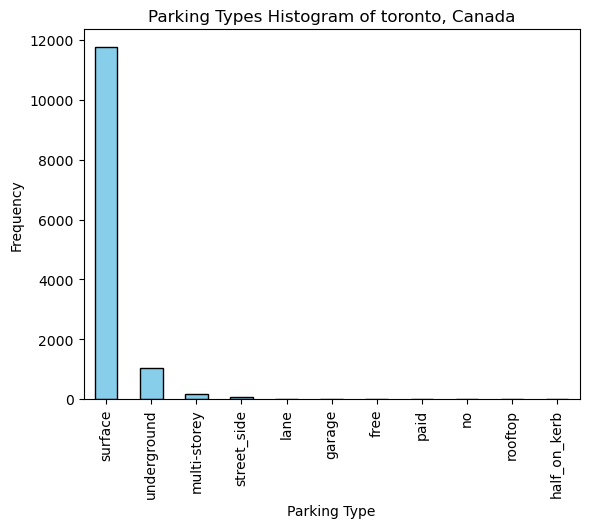

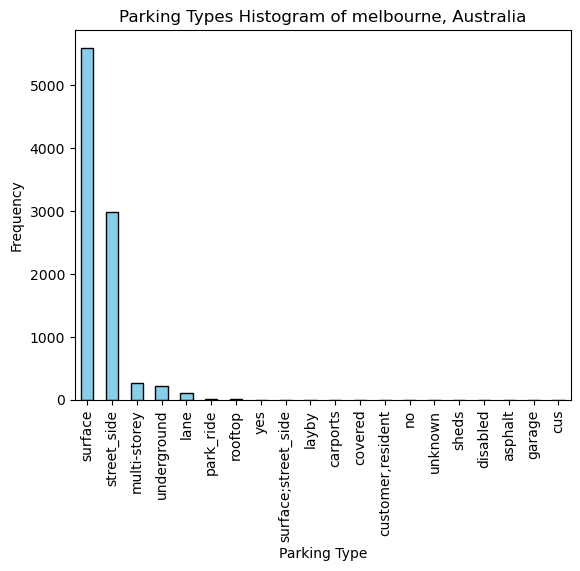

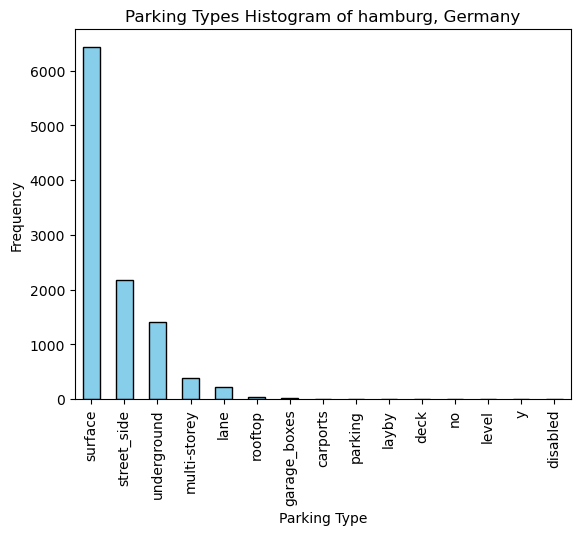

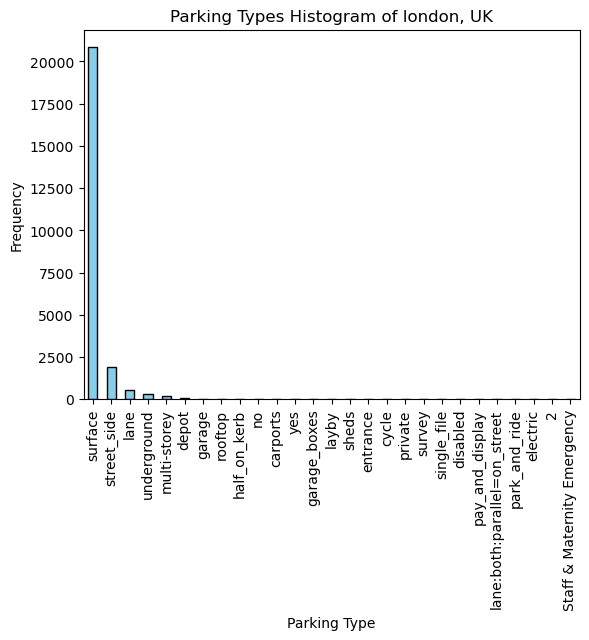

In [34]:
plot_parking_classes(df_parking_paris,cities_int[0])
plot_parking_classes(df_parking_taipeh,cities_int[1])
plot_parking_classes(df_parking_toronto,cities_int[2])
plot_parking_classes(df_parking_melbourne,cities_int[3])
plot_parking_classes(df_parking_hamburg,cities_int[4])
plot_parking_classes(df_parking_london,cities_int[5])


## Inspecting amenities classes

In [37]:
def plot_amenities_classes (df_parking_city,city):
    df_parking_city['amenity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.xlabel('Amenity Type')
    plt.ylabel('Frequency')
    plt.title('Amenity Types Histogram of '+str(city))
    plt.show()
    return

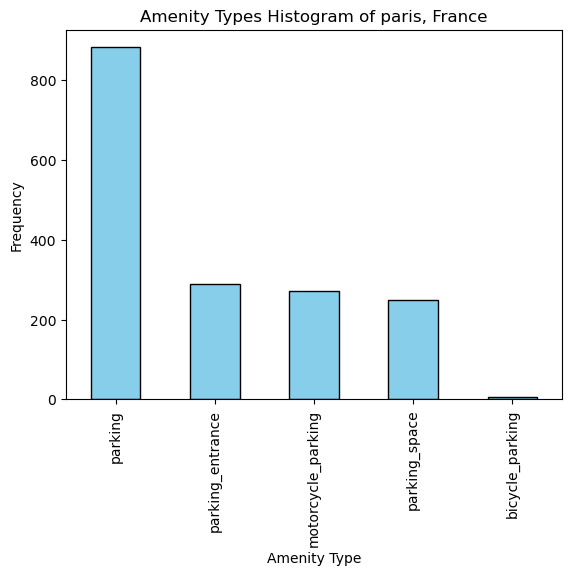

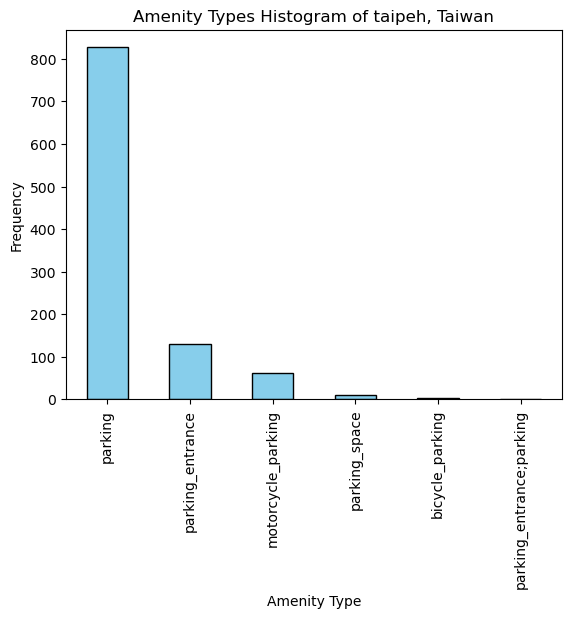

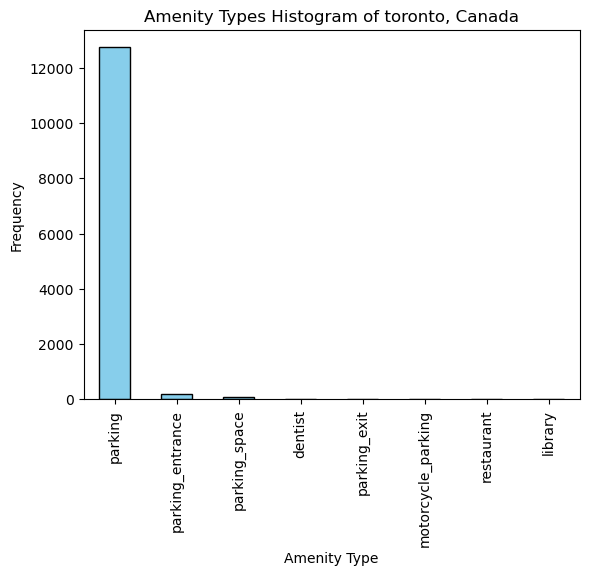

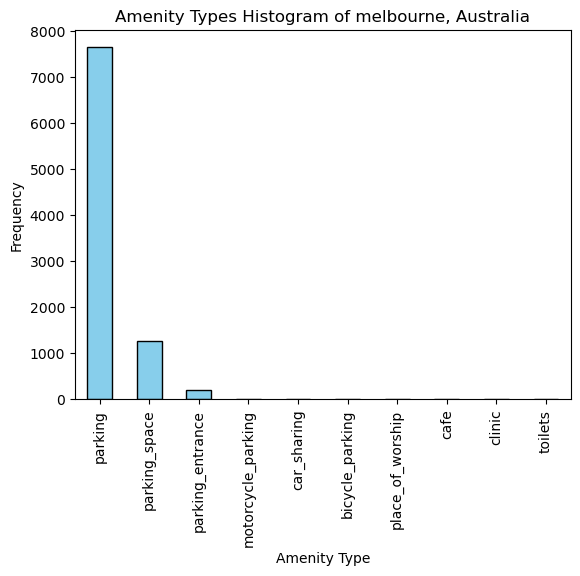

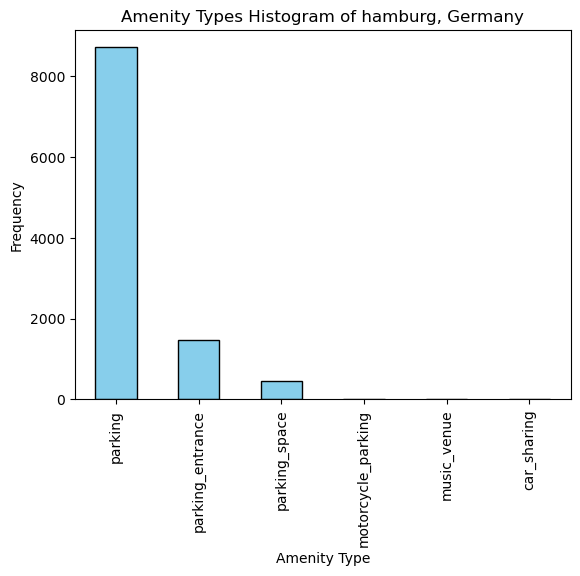

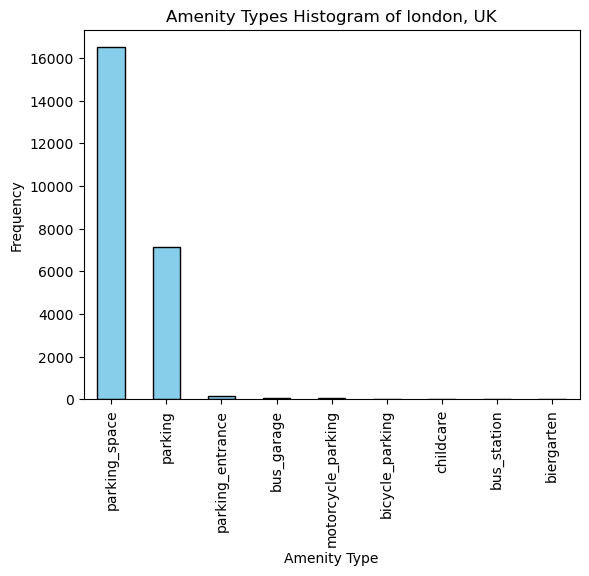

In [38]:
plot_amenities_classes(df_parking_paris,cities_int[0])
plot_amenities_classes(df_parking_taipeh,cities_int[1])
plot_amenities_classes(df_parking_toronto,cities_int[2])
plot_amenities_classes(df_parking_melbourne,cities_int[3])
plot_amenities_classes(df_parking_hamburg,cities_int[4])
plot_amenities_classes(df_parking_london,cities_int[5])

Todo for data cleaning:
>- decide on amenities and parking classes
>- clean tables for relevant parking spots
>- create dataframe with parking spots as observation and parking and amenities and geo data as values

# Data Cleaning

## Translation

In the first step I will translate values that are not in english yet to limit the bias of the dataset. In the taipeh dataset is a parking type "唭哩岸轉乘停車場" that I will change to surface because when googling it looks like this: [link to google results](https://www.google.com/search?sca_esv=595361800&rlz=1C1CHBF_deDE769DE769&sxsrf=AM9HkKn8dVYtCt2txHZahnV96iH8FgS9_g:1704287057944&q=%E5%94%AD%E5%93%A9%E5%B2%B8%E8%BD%89%E4%B9%98%E5%81%9C%E8%BB%8A%E5%A0%B4&tbm=isch&source=lnms&sa=X&ved=2ahUKEwi4_ruFpMGDAxXq1wIHHQuXCawQ0pQJegQIDRAB&biw=1536&bih=703&dpr=1.25). 

![Alt Text](https://www.altob.com.tw/upload/images/%E5%8C%97%E6%8D%B7%E5%94%AD%E5%93%A9%E5%B2%B8_DSC09016.JPG)


In [64]:
df_parking_taipeh['parking'] = df_parking_taipeh['parking'].replace('唭哩岸轉乘停車場', 'surface')

## Adding city description

For each city I will add a column with its city name.

In [66]:
def city_column (df_parking_city, city):
    df_parking_city['city'] = city
    return

In [67]:
city_column(df_parking_paris,cities_int[0])
city_column(df_parking_taipeh,cities_int[1])
city_column(df_parking_toronto,cities_int[2])
city_column(df_parking_melbourne,cities_int[3])
city_column(df_parking_hamburg,cities_int[4])
city_column(df_parking_london,cities_int[5])

## Deleting columns not needed

In [87]:
def clean_city_tables(df_parking_city):
    df_parking_city_clean = df_parking_city.loc[:, ['geometry', 'amenity', 'parking', 'type','city']]
    return df_parking_city_clean

In [89]:
df_parking_paris_clean=clean_city_tables(df_parking_paris)
df_parking_taipeh_clean=clean_city_tables(df_parking_taipeh)
df_parking_toronto_clean=clean_city_tables(df_parking_toronto)
df_parking_melbourne_clean=clean_city_tables(df_parking_melbourne)
df_parking_hamburg_clean=clean_city_tables(df_parking_hamburg)
df_parking_london_clean=clean_city_tables(df_parking_london)

In [92]:
df_parking_paris_clean.head()

geometry           amenity  \
element_type osmid                                                   
node         186469017  POINT (2.35571 48.87582)           parking   
             213173448  POINT (2.35339 48.87304)           parking   
             218117881  POINT (2.34971 48.85695)           parking   
             218119662  POINT (2.35352 48.85630)  parking_entrance   
             241110562  POINT (2.29966 48.84146)  parking_entrance   

                            parking type           city  
element_type osmid                                       
node         186469017  underground  NaN  paris, France  
             213173448  underground  NaN  paris, France  
             218117881  underground  NaN  paris, France  
             218119662  underground  NaN  paris, France  
             241110562  underground  NaN  paris, France

In [100]:
dfs = [df_parking_paris_clean, df_parking_taipeh_clean, df_parking_toronto_clean,
       df_parking_melbourne_clean, df_parking_hamburg_clean, df_parking_london_clean]

# Concatenate the DataFrames horizontally
df_parking_all = pd.concat(dfs, axis=0)

In [101]:
df_parking_all

geometry  \
element_type osmid                                                          
node         186469017                           POINT (2.35571 48.87582)   
             213173448                           POINT (2.35339 48.87304)   
             218117881                           POINT (2.34971 48.85695)   
             218119662                           POINT (2.35352 48.85630)   
             241110562                           POINT (2.29966 48.84146)   
...                                                                   ...   
relation     14531772   POLYGON ((-0.01636 51.37501, -0.01635 51.37503...   
             15268776   POLYGON ((-0.20204 51.61432, -0.20188 51.61438...   
             15268905   POLYGON ((-0.20134 51.61418, -0.20091 51.61438...   
             15395584   POLYGON ((-0.18062 51.61110, -0.18090 51.61122...   
             15903479   POLYGON ((0.08703 51.50166, 0.08705 51.50172, ...   

                                 amenity      parking          type  \
element_type osmid                                                    
node         186469017           parking  underground           NaN   
             213173448           parking  underground           NaN   
             218117881           parking  underground           NaN   
             218119662  parking_entrance  underground           NaN   
             241110562  parking_entrance  underground           NaN   
...                                  ...          ...           ...   
relation     14531772            parking  street_side  multipolygon   
             15268776            parking      surface  multipolygon   
             15268905            parking      surface  multipolygon   
             15395584            parking      surface  multipolygon   
             15903479            parking      surface  multipolygon   

                                 city  
element_type osmid                     
node         186469017  paris, France  
             213173448  paris, France  
             218117881  paris, France  
             218119662  paris, France  
             241110562  paris, France  
...                               ...  
relation     14531772      london, UK  
             15268776      london, UK  
             15268905      london, UK  
             15395584      london, UK  
             15903479      london, UK  

[59679 rows x 5 columns]

## Deleting wrong values

Some data points seem to be wrongly classified as parking spots and will be dropped from the analysis.

In [102]:
df_parking_all.shape

(59679, 5)

In [97]:
values_to_exclude = ['no', 'nan', 'yes','2','survey']  

df_parking_all_clean = df_parking_all[~df_parking_all['parking'].isin(values_to_exclude)]


In [98]:
df_parking_all_clean.shape

(59661, 5)

In [108]:
df_parking_all_clean.head()

geometry           amenity  \
element_type osmid                                                   
node         186469017  POINT (2.35571 48.87582)           parking   
             213173448  POINT (2.35339 48.87304)           parking   
             218117881  POINT (2.34971 48.85695)           parking   
             218119662  POINT (2.35352 48.85630)  parking_entrance   
             241110562  POINT (2.29966 48.84146)  parking_entrance   

                            parking type           city  
element_type osmid                                       
node         186469017  underground  NaN  paris, France  
             213173448  underground  NaN  paris, France  
             218117881  underground  NaN  paris, France  
             218119662  underground  NaN  paris, France  
             241110562  underground  NaN  paris, France

# Saving Shapefile for further work

In [105]:
#not possible to store in asingle shapefile because of different geometry formats
#df_parking_all_clean.to_file('osmnx_parkingdata.shp', driver='ESRI Shapefile')

In [104]:
print(df_parking_all_clean.geometry.geom_type.unique())

['Point' 'LineString' 'Polygon' 'MultiPolygon']


In [107]:
df_parking_all_clean.to_csv('osmnx_parkingdata2.csv', index=False)

In [115]:
filtered_gdf = df_parking_all_clean[df_parking_all_clean['geometry'].geom_type == 'MultiPolygon']

In [116]:
filtered_gdf

geometry  \
element_type osmid                                                         
relation     1517972   MULTIPOLYGON (((2.29582 48.85469, 2.29578 48.8...   
             4601745   MULTIPOLYGON (((121.51433 25.02659, 121.51494 ...   
             10696799  MULTIPOLYGON (((121.54142 25.00066, 121.54150 ...   
             10887346  MULTIPOLYGON (((121.51589 25.04467, 121.51600 ...   
             16805830  MULTIPOLYGON (((121.52051 25.05145, 121.52043 ...   
             13334677  MULTIPOLYGON (((145.12591 -38.10901, 145.12623...   
             14196498  MULTIPOLYGON (((145.12796 -38.10381, 145.12787...   
             14196499  MULTIPOLYGON (((145.12747 -38.10349, 145.12747...   
             14196500  MULTIPOLYGON (((145.12747 -38.10341, 145.12747...   
             15772964  MULTIPOLYGON (((144.96502 -37.75665, 144.96522...   
             15772965  MULTIPOLYGON (((144.96537 -37.75658, 144.96543...   
             16730383  MULTIPOLYGON (((145.07855 -37.68581, 145.07843...   
             16730384  MULTIPOLYGON (((145.07823 -37.68574, 145.07847...   
             9273264   MULTIPOLYGON (((10.02574 53.54492, 10.02634 53...   
             10623359  MULTIPOLYGON (((10.01530 53.55997, 10.01561 53...   
             14151490  MULTIPOLYGON (((-0.42347 51.57255, -0.42349 51...   
             14450768  MULTIPOLYGON (((-0.12848 51.59542, -0.12806 51...   

                                  amenity      parking          type  \
element_type osmid                                                     
relation     1517972              parking      surface  multipolygon   
             4601745              parking      surface  multipolygon   
             10696799             parking      surface  multipolygon   
             10887346  motorcycle_parking      surface  multipolygon   
             16805830             parking      surface  multipolygon   
             13334677             parking      surface  multipolygon   
             14196498             parking      surface  multipolygon   
             14196499             parking  street_side  multipolygon   
             14196500             parking  street_side  multipolygon   
             15772964             parking  street_side  multipolygon   
             15772965             parking  street_side  multipolygon   
             16730383             parking  street_side  multipolygon   
             16730384             parking  street_side  multipolygon   
             9273264              parking     carports  multipolygon   
             10623359             parking      surface  multipolygon   
             14151490             parking      surface  multipolygon   
             14450768             parking      surface  multipolygon   

                                       city  
element_type osmid                           
relation     1517972          paris, France  
             4601745         taipeh, Taiwan  
             10696799        taipeh, Taiwan  
             10887346        taipeh, Taiwan  
             16805830        taipeh, Taiwan  
             13334677  melbourne, Australia  
             14196498  melbourne, Australia  
             14196499  melbourne, Australia  
             14196500  melbourne, Australia  
             15772964  melbourne, Australia  
             15772965  melbourne, Australia  
             16730383  melbourne, Australia  
             16730384  melbourne, Australia  
             9273264       hamburg, Germany  
             10623359      hamburg, Germany  
             14151490            london, UK  
             14450768            london, UK